![image](image/屏幕截图%202025-03-09%20165236.png)

In [9]:
import random
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [10]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self,x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound

class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self,x,a):
        cat = torch.cat([x,a],dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)


In [11]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self,state_dim,hidden_dim,action_dim,action_bound,
                 sigma,actor_lr,critic_lr,tau,gamma,device):
        
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)

        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self,state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        #给动作添加噪声, 增加探索
        action = action + self.sigma * np.random.random(self.action_dim)
        return action
    
    def soft_update(self, net, target_net):
        ''' 软更新: 让目标Q网络参数逐渐接近Q网络 '''
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau)) + param.data * self.tau

    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络




以下是链接内容的总结，分点列出关键信息：

---

### **1. 环境概述**
- **名称**：`Pendulum-v1`
- **类型**：经典控制问题（倒立摆摆动上升），目标是通过施加扭矩使摆杆竖直平衡。
- **维护库**：Gymnasium（OpenAI Gym的分支，由Farama Foundation维护）。

---

### **2. 核心参数**
- **动作空间（Action Space）**  
  - 类型：`Box(-2.0, 2.0, (1,), float32)`  
  - 含义：单维度扭矩值，范围 `[-2.0, 2.0]`（单位：N·m），正值为逆时针扭矩。

- **观察空间（Observation Space）**  
  - 类型：`Box([-1, -1, -8], [1, 1, 8], (3,), float32)`  
  - 包含三个特征：  
    1. `x = cos(theta)`（摆杆末端x坐标）  
    2. `y = sin(theta)`（摆杆末端y坐标）  
    3. 角速度（范围 `[-8, 8]` rad/s）。

---

### **3. 奖励函数**
- **公式**：  
  `r = -(theta² + 0.1 * theta_dt² + 0.001 * torque²)`  
  - `theta`：归一化到 `[-π, π]` 的角度（0为竖直状态）。  
  - `theta_dt`：角速度，`torque`：施加的扭矩。  
- **奖励范围**：  
  - 最小值：`-16.2736044`（摆杆下垂且高速旋转）  
  - 最大值：`0`（摆杆竖直静止，无扭矩）。

---

### **4. 初始状态与终止条件**
- **初始状态**：  
  - 随机角度 `theta ∈ [-π, π]`  
  - 随机角速度 `theta_dt ∈ [-1, 1]` rad/s。
- **截断条件**：  
  - 默认每回合最多 **200步**（超过后自动终止，无自然终止状态）。

---

### **5. 物理参数与自定义**
- **重力加速度**：  
  - 默认 `g = 10.0 m/s²`，可通过 `gymnasium.make("Pendulum-v1", g=9.81)` 修改。
- **初始状态随机范围**：  
  - 可通过 `reset(options={"low": -0.7, "high": 0.5})` 调整角度和角速度的随机区间。

---

### **6. 版本历史**
- **v1**：仅简化了数学公式的描述，**行为与v0完全一致**（无功能变化）。  
- **v0**：初始版本（已弃用，建议使用v1）。

---

### **7. 关键区别澄清**
- **与旧版OpenAI Gym的差异**：  
  - 在Gymnasium中，**Pendulum-v1的奖励函数仍为连续形式**（非稀疏奖励），动作范围保持 `[-2, 2]`，与用户此前问题中提到的OpenAI Gym旧版环境可能不同。  
  - 版本更新仅涉及文档描述优化，无算法或物理逻辑调整。

---

### **总结**  
Gymnasium的Pendulum-v1是一个连续控制的经典环境，核心挑战是通过扭矩控制倒立摆竖直平衡。其设计保留了OpenAI Gym的原始逻辑，仅优化了文档表述。若需验证算法在稀疏奖励或不同动作范围下的性能，需自行修改环境或使用其他变体。

In [ ]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 200
hidden_dim = 256
gamma = 0.99
tau = 0.01  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 256
sigma = 0.1  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 3:  95%|█████████▌| 19/20 [00:33<00:01,  1.78s/it, episode=70, return=-1403.919]

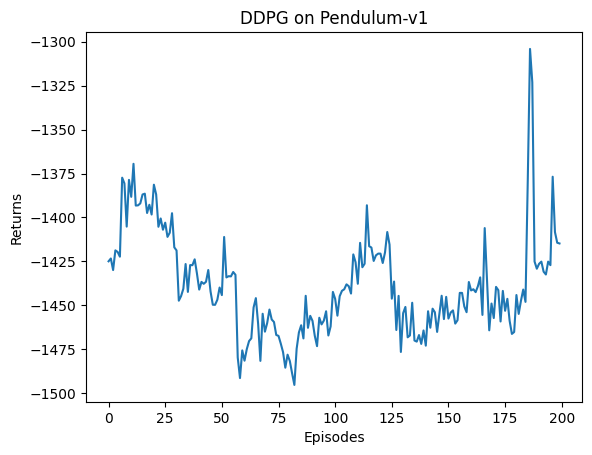

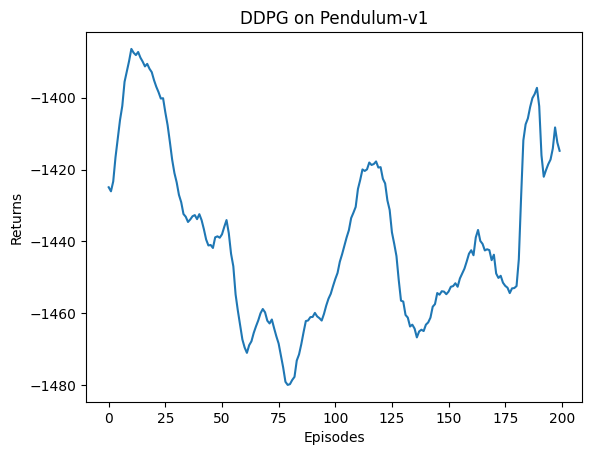

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()